In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

Importing pyfftw first


2024-06-10 16:41:31.691834: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 16:41:38.370982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 16:41:38.388518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 16:42:43.342357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-10 16:44:09.618569: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

### Set up bacco: cosmology and power spectrum parameters

In [9]:
idx_LH = 0
idx_LH_str = str(idx_LH)
tag_mocks = ''
dir_mocks = f'../data/cosmolib{tag_mocks}'

tag_mocks_hr = '_HR'
dir_mocks_hr = f'../data/cosmolib{tag_mocks_hr}'

# order of saved cosmo param files
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
    
n_grid = 128
n_grid_orig = 512
box_size = 1000.0

In [3]:
def get_cosmo(param_dict):
    a_scale = 1
    # omega_m = omega_cold + omega_neutrinos 
    # (omega_m = omega_cold if no neutrinos) 
    # Om_cdm = Om_cold - Om_baryon
    if 'omega_m' in param_dict:
        omega_cdm = param_dict['omega_m']-param_dict['omega_baryon']
    elif 'omega_cold' in param_dict:
        omega_cdm = param_dict['omega_cold']-param_dict['omega_baryon']
    else:
        raise ValueError("param_dict must include omega_m or omega_cold!")

    cosmopars = dict(
            omega_cdm=omega_cdm,
            omega_baryon=param_dict['omega_baryon'],
            hubble=param_dict['h'],
            ns=param_dict['n_s'],
            sigma8=param_dict['sigma_8'],
            tau=0.0561,
            A_s=None,
            neutrino_mass=0.,
            w0=-1,
            wa=0,
        )

    cosmo = bacco.Cosmology(**cosmopars)
    cosmo.set_expfactor(a_scale)
    return cosmo

In [4]:
fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names_all, param_vals))
del param_dict['seed']
print(param_dict)
cosmo_Quijote = get_cosmo(param_dict)


2024-06-10 16:44:16,550 bacco.cosmo :    initialization took 0.000 secs


{'omega_cold': 0.2775274936564327, 'sigma_8': 0.7049140324569382, 'h': 0.7241123952301097, 'omega_baryon': 0.049, 'n_s': 0.9624}


In [5]:
k_min = 0.01
k_max = 1.0
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = True

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    "ngrid": n_grid,
    "box": box_size,
    #"pos": None,
    "vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    "zspace": False,
    "cosmology": cosmo_Quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    "ngrid": n_grid,
    "box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    "cosmology": cosmo_Quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'ngrid': n_grid,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})


## Load eulerian fields

In [6]:
def get_tracer_field(bias_fields_eul, bias_vector, n_grid_norm=512):

    def _sum_bias_fields(fields, bias_vector):
        bias_vector_extended = np.concatenate(([1.0], bias_vector))
        return np.sum([fields[ii]*bias_vector_extended[ii] for ii in range(len(bias_vector))], axis=0)
    
    tracer_field_eul = _sum_bias_fields(bias_fields_eul, bias_vector)
    tracer_field_eul_norm = tracer_field_eul/n_grid_norm**3
    
    return tracer_field_eul_norm

In [11]:
tag_fields = '_lr'
tag_fields_extra = ''
fn_fields = f'{dir_mocks}/LH{idx_LH}/Eulerian_fields{tag_fields}_{idx_LH}{tag_fields_extra}.npy'
bias_vector = [0.,0.,0.,0.]

bias_terms_eul = np.load(fn_fields)
print(bias_terms_eul.shape)
if n_grid_orig is None:
    n_grid_orig = bias_terms_eul.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field = get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field.shape)

(5, 128, 128, 128)
n_grid_orig = 512
(128, 128, 128)


In [13]:
tag_fields_hr = '_hr'
tag_fields_extra_hr = ''
fn_fields_hr = f'{dir_mocks_hr}/LH{idx_LH}/Eulerian_fields{tag_fields_hr}_{idx_LH}{tag_fields_extra_hr}.npy'
bias_vector = [0.,0.,0.,0.]

bias_terms_eul_hr = np.load(fn_fields_hr)
print(bias_terms_eul_hr.shape)
bias_terms_eul_hr = np.squeeze(bias_terms_eul_hr)
print(bias_terms_eul_hr.shape)

if n_grid_orig is None:
    n_grid_orig = bias_terms_eul_hr.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field_hr = get_tracer_field(bias_terms_eul_hr, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field_hr.shape)

(5, 1, 512, 512, 512)
(5, 512, 512, 512)
n_grid_orig = 512
(512, 512, 512)


Put displacements on mesh

-5.281733592710225e-06 2.242089067294728e-05
-5.281733592710225e-06 2.242089067294728e-05


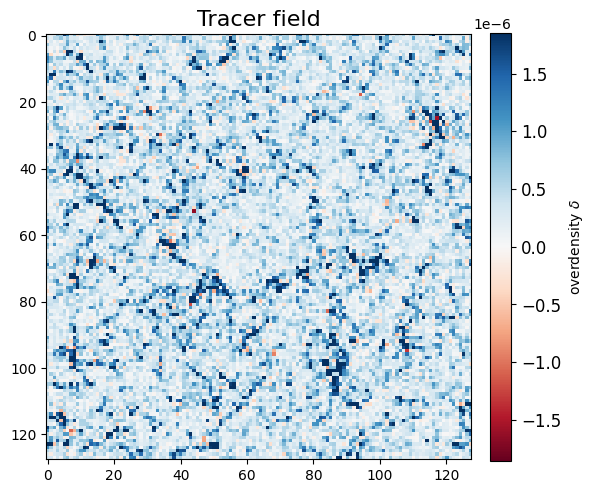

In [14]:
plotter.plot_overdensity_field(tracer_field, title=r'Tracer field',
                               #vmax=0.1
                               )

0.0 6.4598798417137004e-06
0.0 6.4598798417137004e-06


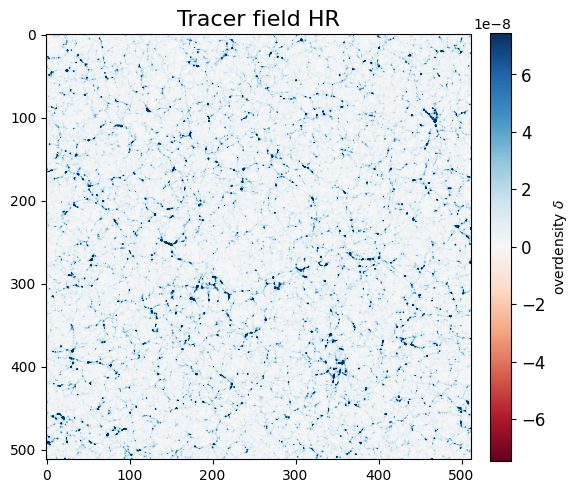

In [15]:
plotter.plot_overdensity_field(tracer_field_hr, title=r'Tracer field HR',
                               #vmax=0.1
                               )

### Compute power spectra of fields

In [16]:
pk_obj_mesh = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid)

2024-06-10 16:48:35,593 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-10 16:48:36,875 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.481 secs
2024-06-10 16:48:36,880 bacco.cosmo :    created Pk(z=0) tab from k 6.905005284352228e-05 to 100000.0 h/Mpc
2024-06-10 16:48:36,885 bacco.cosmo :    computed halofit at z=0.00 for 'Default' in 0.002 secs
2024-06-10 16:48:37,048 bacco.statistics :  ...done in 1.45 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007101 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.047055 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


In [21]:
args_power_grid_deconvolveFalse = args_power_grid.copy()
args_power_grid_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_deconvolveFalse['deconvolve_grid2'] = False

pk_obj_mesh_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid_deconvolveFalse)

2024-06-10 16:49:21,093 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.035360 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.102533 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000462 secs
bacco.power : Deallocating arrays


2024-06-10 16:49:21,469 bacco.statistics :  ...done in 0.376 s


In [22]:
args_power_grid_correctgridTrue = args_power_grid.copy()
args_power_grid_correctgridTrue['correct_grid'] = True

pk_obj_mesh_correctgridTrue = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid_correctgridTrue)

2024-06-10 16:49:25,218 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-10 16:49:25,352 bacco.statistics :  ...done in 0.133 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.012644 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.047258 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000417 secs
bacco.power : Deallocating arrays


In [25]:
print("hi")

hi


In [29]:
args_power_grid_hr = args_power_grid.copy()
args_power_grid_hr['ngrid'] = 512

In [30]:

pk_obj_mesh_hr = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr)

2024-06-10 17:31:46,512 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.081412 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.768282 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000457 secs
bacco.power : Deallocating arrays


2024-06-10 17:31:55,172 bacco.statistics :  ...done in 8.66 s


In [40]:
args_power_grid_hr_deconvolveFalse = args_power_grid_hr.copy()
args_power_grid_hr_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_hr_deconvolveFalse['deconvolve_grid2'] = False

pk_obj_mesh_hr_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr_deconvolveFalse)

2024-06-10 17:33:47,469 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.211790 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.777515 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000421 secs
bacco.power : Deallocating arrays


2024-06-10 17:33:55,443 bacco.statistics :  ...done in 7.97 s


### Load in emulators, compute emu P(k)'s

In [31]:
emu_mpk_ext, emu_bounds_mpk_ext, emu_param_names_mpk_ext = utils.load_emu(emu_name='mpk_extended')
emu_bounds_dict_mpk_ext = dict(zip(emu_param_names_mpk_ext, emu_bounds_mpk_ext))

Loading sigma8 emulator...
HIIII
Sigma8 emulator loaded in memory.
Loading linear emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using v

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [32]:
# Careful, these are diff than quijote, so order of running this nb matters
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'h': 'hubble',
                                 'n_s': 'ns',
                                 'omega_baryon': 'omega_baryon'
                                 }

In [33]:
kk = pk_obj_mesh['k']

In [34]:

cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [35]:
param_names_fromdict = list(param_dict.keys())

#for param_name in param_names:
for param_name in param_names_fromdict:
    if param_name=='omega_m':
        # no neutrinos, so omega_cold = omega_m
        emu_param_name = 'omega_cold'
    else:
        emu_param_name = param_names_2_emu_param_names[param_name]
    cosmo_params[emu_param_name] = param_dict[param_name]

_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True,
                                                        **cosmo_params)

### Check cosmos

In [36]:
param_dict

{'omega_cold': 0.2775274936564327,
 'sigma_8': 0.7049140324569382,
 'h': 0.7241123952301097,
 'omega_baryon': 0.049,
 'n_s': 0.9624}

In [37]:
cosmo_params

{'neutrino_mass': 0.0,
 'w0': -1.0,
 'wa': 0.0,
 'expfactor': 1,
 'omega_cold': 0.2775274936564327,
 'sigma8_cold': 0.7049140324569382,
 'hubble': 0.7241123952301097,
 'omega_baryon': 0.049,
 'ns': 0.9624}

In [38]:
cosmo_Quijote.pars

{'hubble': 0.7241123952301097,
 'sigma8': 0.7049140324569382,
 'A_s': None,
 'omega_baryon': 0.049,
 'omega_cdm': 0.2285274936564327,
 'w0': -1,
 'wa': 0,
 'ns': 0.9624,
 'tau': 0.0561,
 'approx_nu': False,
 'num_massive_neutrinos': 0,
 'neutrino_mass': 0.0,
 'Neffective': 3.046,
 'DeltaNeff': 3.046,
 'GammaNu': 0.71611,
 'omega_neutrino': 0.0,
 'omega_matter': 0.2775274936564327,
 'omega_cold': 0.2775274936564327,
 'photon_temperature': 2.7255,
 'omega_photons': 0.0,
 'omega_rad': 0.0,
 'omega_de': 0.7224725063435673,
 'omega_k': 0.0,
 'omega_tot': 1.0}

### Plot

/tmp/ipykernel_380209/4066074678.py:63: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
/tmp/ipykernel_380209/4066074678.py:64: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


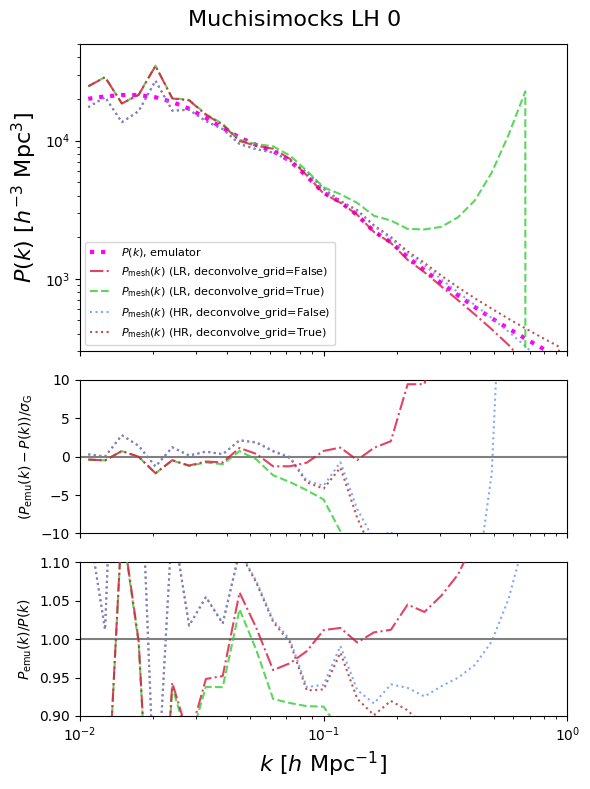

In [44]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

# labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
#           #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
#           r'$P_\text{part}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n interlacing=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n correct_grid=False)',
#           r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
#           ]
labels = [r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=True)',
          #r'$P_\text{mesh}(k)$ (deconvolve_grid=True, correct_grid=True)',
          r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=True)']
colors = ['crimson', 'limegreen', 'cornflowerblue', 'brown', 'orange', 'darkblue',]
lss = ['-.', '--', ':', ':', '--', '-']
# pk_objs = [pk_obj_particles_nodeconv,
#            pk_obj_particles,
#            pk_obj_particles_interlacing,
#            pk_obj_particles_nocorrectgrid,
#            pk_obj_mesh, 
#            #pk_obj_particles_deconv_Mpcperh, 
#            #pk_obj_pos_mesh_deconv, 
#            pk_obj_snap,
#            ]
pk_objs = [pk_obj_mesh_deconvolveFalse,
           pk_obj_mesh,
           #pk_obj_mesh_correctgridTrue,
           pk_obj_mesh_hr_deconvolveFalse,
           pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=3)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()